# Load libraries

In [1]:
import os
import warnings

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import torch
from torch import nn
import h5py
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Read Data

In [2]:
DATA_FOLDER = "../input"

all_paths = [
    os.path.join(path, file) for path, _, files in os.walk(top=DATA_FOLDER)
    for file in files 
    if file.endswith('.labels') or file.endswith('.txt')
]

label_names = {0: 'unlabeled', 
               1: 'man-made terrain', 
               2: 'natural terrain', 
               3: 'high vegetation', 
               4: 'low vegetation', 
               5: 'buildings', 
               6: 'hard scape', 
               7: 'scanning artefacts', 
               8: 'cars'}

all_paths

['../input/sem8_labels_training/sem8_labels_training/sg27_station9_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/bildstein_station5_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/sg28_station4_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/sg27_station4_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/untermaederbrunnen_station3_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/bildstein_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/untermaederbrunnen_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/domfountain_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/neugasse_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/domfountain_station3_xyz_intensity_rgb.labels',
 '../input/sem8_

In [3]:
all_files_df = pd.DataFrame({'path': all_paths})
all_files_df['basename'] = all_files_df['path'].map(os.path.basename)
all_files_df['id'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[0])
all_files_df['ext'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[1][1:])
all_files_df.sample(3)

,path,basename,id,ext
9,../input/sem8_labels_training/sem8_labels_trai...,domfountain_station3_xyz_intensity_rgb.labels,domfountain_station3_xyz_intensity_rgb,labels
13,../input/sem8_labels_training/sem8_labels_trai...,domfountain_station2_xyz_intensity_rgb.labels,domfountain_station2_xyz_intensity_rgb,labels
2,../input/sem8_labels_training/sem8_labels_trai...,sg28_station4_intensity_rgb.labels,sg28_station4_intensity_rgb,labels


In [4]:
all_training_pairs = all_files_df.pivot_table(values = 'path', 
                                              columns = 'ext', 
                                              index = ['id'], 
                                              aggfunc = 'first').reset_index().dropna()
all_training_pairs

ext,id,labels,txt
0,bildstein_station1_xyz_intensity_rgb,../input/sem8_labels_training/sem8_labels_trai...,../input/bildstein_station1_xyz_intensity_rgb/...
3,domfountain_station1_xyz_intensity_rgb,../input/sem8_labels_training/sem8_labels_trai...,../input/domfountain_station1_xyz_intensity_rg...


In [5]:
_, test_row = next(all_training_pairs.dropna().tail(1).iterrows())
print(test_row)
read_label_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['class'], index_col = False)
read_xyz_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b'], header = None) #x, y, z, intensity, r, g, b
read_joint_data = lambda c_row, rows: pd.concat([read_xyz_data(c_row['txt'], rows), read_label_data(c_row['labels'], rows)], axis = 1)
read_joint_data(test_row, 10)

ext
id                   domfountain_station1_xyz_intensity_rgb
labels    ../input/sem8_labels_training/sem8_labels_trai...
txt       ../input/domfountain_station1_xyz_intensity_rg...
Name: 3, dtype: object


,x,y,z,intensity,r,g,b,class
0,-22.586,-72.368,0.640,-1365,227,226,231,0
1,-22.580,-72.500,-0.009,-1353,82,87,107,0
2,-22.603,-72.498,-0.030,-1367,96,108,134,0
3,-22.511,-72.496,-0.050,-1349,85,82,91,0
4,-22.512,-72.499,-0.037,-1368,83,80,89,0
5,-23.377,-78.032,-0.104,-1543,73,76,85,0
6,-22.535,-72.499,-0.058,-1344,85,84,92,0
7,-22.556,-72.495,-0.053,-1337,80,79,93,0
8,-22.535,-72.497,-0.036,-1367,84,81,90,0
9,-22.721,-72.514,-0.766,-1473,88,80,93,0


In [6]:
df = read_joint_data(test_row, None)
df.shape

(44990641, 8)

In [7]:
le = LabelEncoder()

df["class"] = le.fit_transform(df["class"])
sorted(df["class"].unique())

[0, 1, 2, 3, 4, 5, 6, 7]

# EDA

In [8]:
fraction = 0.1
sample = df.sample(frac=fraction)

CPU times: user 685 ms, sys: 216 ms, total: 902 ms
Wall time: 905 ms


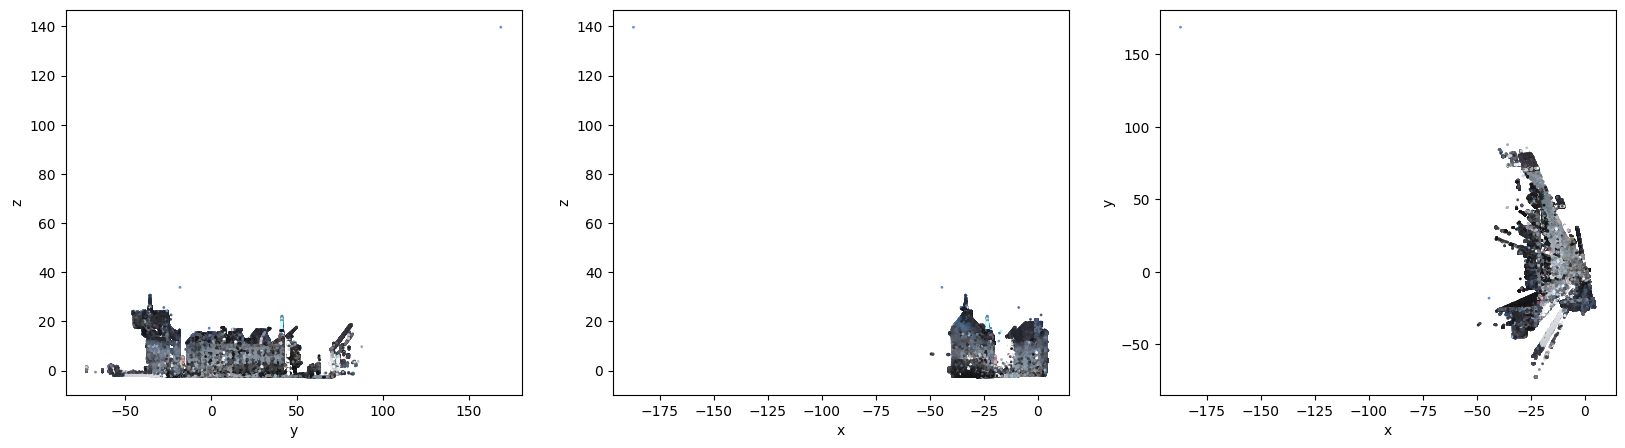

In [9]:
%%time
fig, m_axs = plt.subplots(1, 3, figsize = (20, 5))
ax_names = 'xyz'
for i, c_ax in enumerate(m_axs.flatten()):
    plot_axes = [x for j, x in enumerate(ax_names) if j!=i]
    c_ax.scatter(sample[plot_axes[0]],
                sample[plot_axes[1]],
                c=sample[['r', 'g', 'b']].values / 255, 
                 s=1
                )
    c_ax.set_xlabel(plot_axes[0])
    c_ax.set_ylabel(plot_axes[1])

CPU times: user 1.3 s, sys: 208 ms, total: 1.51 s
Wall time: 1.51 s


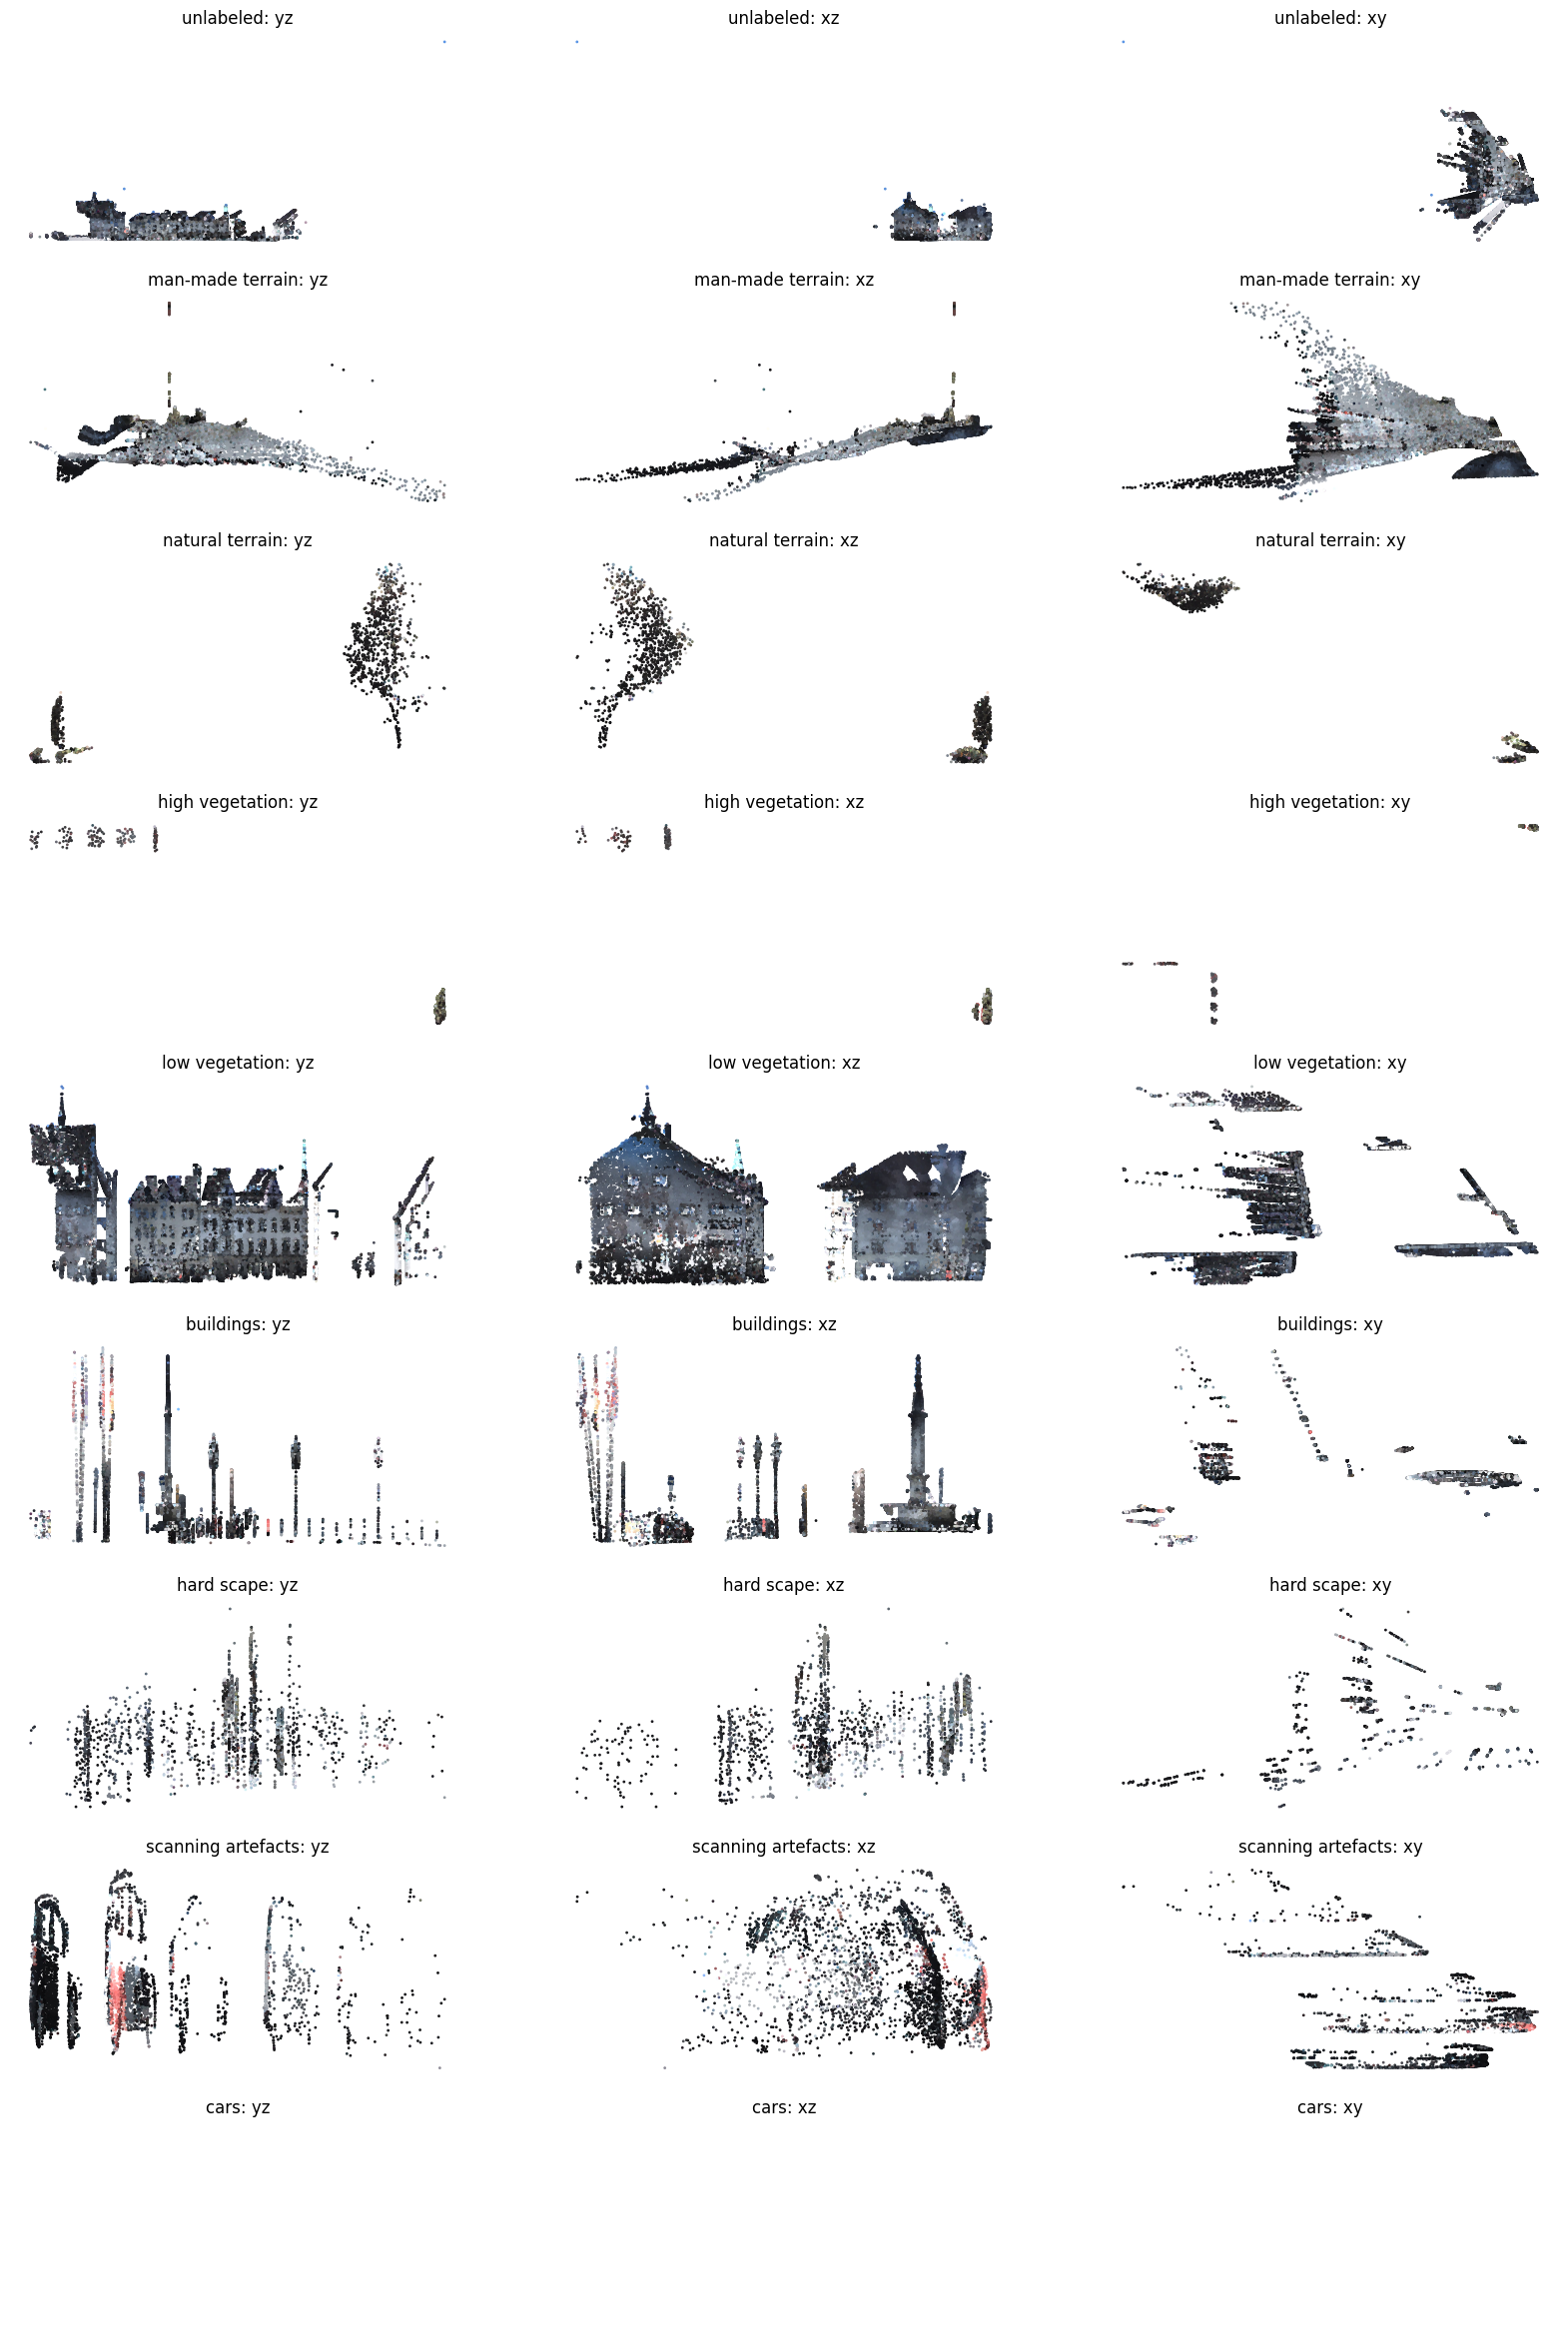

In [10]:
%%time
ax_names = 'xyz'

max_keys = max(label_names.keys())
fig, m_axs = plt.subplots(max_keys + 1, 3, figsize = (20, 30))
for i, c_axs in enumerate(m_axs.T):
    plot_axes = [x for j, x in enumerate(ax_names) if j != i]
    for c_ax, (c_key, c_value) in zip(c_axs, label_names.items()):
        c_df = sample[sample['class'] == c_key]
        c_ax.scatter(
            c_df[plot_axes[0]].values,
            c_df[plot_axes[1]].values,
            c=c_df[["r", "g", "b"]].values / 255,
            label = c_value,
            s=1
        )
        c_ax.set_title('{}: {}'.format(c_value, ''.join(plot_axes)))
        c_ax.set_xlabel(plot_axes[0])
        c_ax.set_ylabel(plot_axes[1])
        c_ax.axis('off')

# Clean data

/tmp/ipykernel_5079/834474999.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["x"], ax=axs[0], kde=False)
/tmp/ipykernel_5079/834474999.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["y"], ax=axs[1], kde=False)
/tmp/ipykernel_5079/834474999.py:4: UserWarning: 

`distplot` is a dep

<Axes: xlabel='z'>

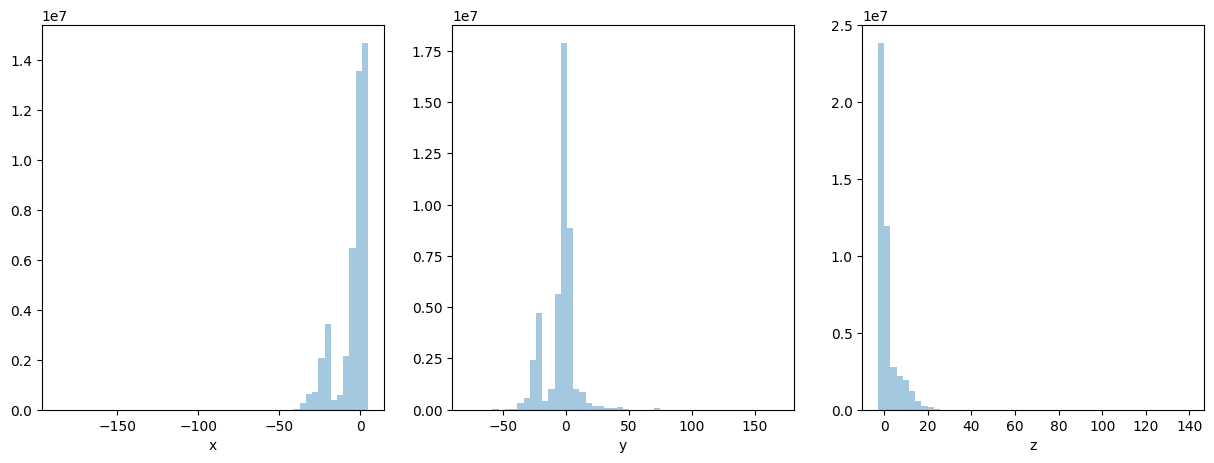

In [11]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.distplot(df["x"], ax=axs[0], kde=False)
sns.distplot(df["y"], ax=axs[1], kde=False)
sns.distplot(df["z"], ax=axs[2], kde=False)

In [12]:
df = df[
    (-50 <= df["x"]) &
    ((-50 <= df["y"]) & (df["y"] <= 50)) &
    (df["z"] <= 25)
]

In [13]:
df = df.dropna()
df.shape

(44825007, 8)

# Preparation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [15]:
features = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b']
target = "class"

X, y = df[features], df[target]

# CatBoost

In [16]:
from catboost import CatBoostClassifier

In [17]:
N_SPLITS=6
RANDOM_STATE=42
SHUFFLE=True

scores = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=SHUFFLE)

for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostClassifier(
        verbose=100,
        task_type="GPU",
        random_state=42
    )
    
    model.fit(
        X_train, 
        y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100
    )

    preds = model.predict(X_val)

    score = {
        "Balanced Accuracy": balanced_accuracy_score(y_val, preds),
        "Accuracy": accuracy_score(y_val, preds),
        "F1 Weighted": f1_score(y_val, preds, average='weighted'),
    }
    print(score)
    
    scores.append(score)

Learning rate set to 0.304535
0:	learn: 1.0696421	test: 1.0695928	best: 1.0695928 (0)	total: 135ms	remaining: 2m 14s
100:	learn: 0.5225362	test: 0.5224669	best: 0.5224669 (100)	total: 13.1s	remaining: 1m 56s
200:	learn: 0.5211387	test: 0.5211297	best: 0.5211297 (200)	total: 26s	remaining: 1m 43s
300:	learn: 0.5204269	test: 0.5204933	best: 0.5204933 (300)	total: 39.5s	remaining: 1m 31s
400:	learn: 0.5200565	test: 0.5201881	best: 0.5201881 (400)	total: 52.6s	remaining: 1m 18s
500:	learn: 0.5198755	test: 0.5200742	best: 0.5200246 (483)	total: 1m 5s	remaining: 1m 5s
600:	learn: 0.5196288	test: 0.5198917	best: 0.5198917 (600)	total: 1m 19s	remaining: 52.6s
700:	learn: 0.5194449	test: 0.5197653	best: 0.5197653 (700)	total: 1m 32s	remaining: 39.4s
800:	learn: 0.5193311	test: 0.5197077	best: 0.5197077 (800)	total: 1m 45s	remaining: 26.2s
900:	learn: 0.5192033	test: 0.5196214	best: 0.5196214 (900)	total: 1m 58s	remaining: 13s
999:	learn: 0.5190906	test: 0.5195603	best: 0.5195603 (999)	total: 2m

In [18]:
baccs = []
accs = []
f1s = []

for score in scores:
    baccs.append(score["Balanced Accuracy"])
    accs.append(score["Accuracy"])
    f1s.append(score["F1 Weighted"])
    
mean_balanced_acc = np.mean(baccs)
std_balanced_acc = np.std(baccs)

mean_acc = np.mean(accs)
std_acc = np.std(accs)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

print(f"Balanced Accuracy: {mean_balanced_acc} ± {std_balanced_acc}")
print(f"Accuracy: {mean_acc} ± {std_acc}")
print(f"F1 Weighted: {mean_f1} ± {std_f1}")

Balanced Accuracy: 0.23863997353712652 ± 0.00709645892466967
Accuracy: 0.7776829795036764 ± 6.898944992734461e-05
F1 Weighted: 0.6806933279840649 ± 6.020552613496673e-05
